# **imports**

In [6]:
%load_ext autoreload
%autoreload 2

In [87]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import pandas as pd


In [185]:
import os
import sys
sys.path.append("../")

from modules.utils import load_json, get_pooled_IPL_positions, get_template, get_interpolated_templates, get_downsampled_data, get_cone_tunings, get_log_opsin_tunings, get_list_of_colors, get_closest_wavelength
from modules.preprocessing import pool_avg_traces, get_baseline_subtracted_traces
from modules.masking import get_masked_traces
from modules.model import fit_model

In [3]:
plt.rcParams["figure.autolayout"] = True

# **load data**

In [104]:
qc = 0.35 # quality criterion to evaluate traces
std_qc = 1
nLEDs = 6 # number of LEDs used in a given experiment
fpath_expinfo = r'../experiment_info/zf_leds_for_analysis.json'
led_nms = load_json(fpath_expinfo)
led_nms_num = np.array([int(led) for led in led_nms])
cmap_list = get_list_of_colors(nLEDs, red_first=True)

In [18]:
# get average traces
fpath_control = r"D:\Project_with_Chiara\analysis_clean\data\control"
fpath_red = r"D:\Project_with_Chiara\analysis_clean\data\red"
fpath_green = r"D:\Project_with_Chiara\analysis_clean\data\green"
fpath_blue = r"D:\Project_with_Chiara\analysis_clean\data\blue"
fpath_uv = r"D:\Project_with_Chiara\analysis_clean\data\uv"


pooled_traces_control, pooled_triggerstamps_control, pooled_ticks_control, pooled_baselines_control, pooled_quality_criterion_control = pool_avg_traces(fpath_control, fpath_expinfo, nLEDs)
pooled_traces_bs_control = get_baseline_subtracted_traces(pooled_traces_control, pooled_baselines_control, snippets=False)

pooled_traces_red, pooled_triggerstamps_red, pooled_ticks_red, pooled_baselines_red, pooled_quality_criterion_red = pool_avg_traces(fpath_red, fpath_expinfo, nLEDs)
pooled_traces_bs_red = get_baseline_subtracted_traces(pooled_traces_red, pooled_baselines_red, snippets=False)

pooled_traces_green, pooled_triggerstamps_green, pooled_ticks_green, pooled_baselines_green, pooled_quality_criterion_green = pool_avg_traces(fpath_green, fpath_expinfo, nLEDs)
pooled_traces_bs_green = get_baseline_subtracted_traces(pooled_traces_green, pooled_baselines_green, snippets=False)

pooled_traces_blue, pooled_triggerstamps_blue, pooled_ticks_blue, pooled_baselines_blue, pooled_quality_criterion_blue = pool_avg_traces(fpath_blue, fpath_expinfo, nLEDs)
pooled_traces_bs_blue = get_baseline_subtracted_traces(pooled_traces_blue, pooled_baselines_blue, snippets=False)

pooled_traces_uv, pooled_triggerstamps_uv, pooled_ticks_uv, pooled_baselines_uv, pooled_quality_criterion_uv = pool_avg_traces(fpath_uv, fpath_expinfo, nLEDs)
pooled_traces_bs_uv = get_baseline_subtracted_traces(pooled_traces_uv, pooled_baselines_uv, snippets=False)

14it [00:09,  1.41it/s]


final shape of pooled traces: 1917 rois | 18000  time points


15it [00:09,  1.58it/s]


final shape of pooled traces: 2238 rois | 18000  time points


8it [00:04,  1.84it/s]


final shape of pooled traces: 1039 rois | 18000  time points


9it [00:04,  1.95it/s]


final shape of pooled traces: 1045 rois | 18000  time points


14it [00:09,  1.46it/s]

final shape of pooled traces: 2058 rois | 18000  time points


In [17]:
# get the IPL positions and the regions of the rois
pooled_IPLs_control, pooled_regions_control = get_pooled_IPL_positions(fpath_control)
pooled_IPLs_uv, pooled_regions_uv = get_pooled_IPL_positions(fpath_uv)
pooled_IPLs_green, pooled_regions_green = get_pooled_IPL_positions(fpath_green)
pooled_IPLs_red, pooled_regions_red = get_pooled_IPL_positions(fpath_red)
pooled_IPLs_blue, pooled_regions_blue = get_pooled_IPL_positions(fpath_blue)

0it [00:00, ?it/s]

final shape of pooled IPL positions: 1917 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 2058 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 1039 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 2238 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 1045 rois


# **template matching**

## **get templates**

In [135]:
# get the template
ticks_per_template = 200
path_to_template = r"..\experiment_info\model\fitting_templates.mat"
templates = get_template(path_to_template, temp_type='3s')
templates = get_interpolated_templates(templates, num_of_ds_ticks=ticks_per_template)

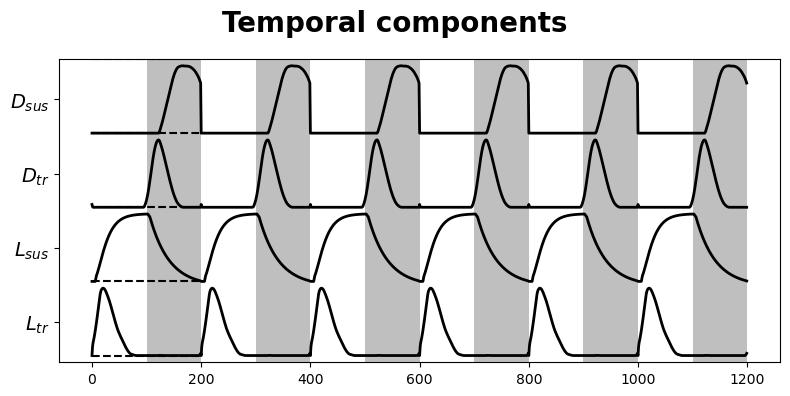

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
temp_labels = [r'$L_{tr}$', r'$L_{sus}$', r'$D_{tr}$', r'$D_{sus}$']
fig.suptitle('Temporal components', fontsize=20, fontweight='bold')
expand_templates = np.zeros((nLEDs*templates.shape[0], templates.shape[1]))
for i in range(nLEDs):
    expand_templates[i*templates.shape[0]:(i+1)*templates.shape[0]] = templates
    
    
for i in range(templates.shape[1]):
    ax.plot(expand_templates[:, i] + i*1.1, 'k', lw=2)
# ax.vlines(100, -0.1, 4.1, ls='--', lw = 2, color='k')
for i in range(nLEDs):
    ax.axvspan(ticks_per_template*i+ticks_per_template/2, ticks_per_template*i+ticks_per_template, 0, 4.1, facecolor='gray', alpha=0.5)
    ax.hlines(i*1.1, 0, templates.shape[0], 'k', '--')

ax.yaxis.set_ticks([i*1.1+0.5 for i in range(templates.shape[1])], temp_labels, fontsize=14)
ax.set_ylim(-0.1, 4.4)
plt.tight_layout()

## **downsample traces**

In [141]:
def get_downsampled_data2(pooled_traces: np.array, num_of_templates_ticks: int) -> np.array:
    """Downsamples the input data to the desired number of ticks.
    
    Args:
        pooled_traces (np.array): The input data to be downsampled.
        num_of_templates_ticks (int): The desired number of ticks in the downsampled data.
        
    Returns:
        np.array: The downsampled data.
    """
    # Calculate the downsampling factor to achieve the desired number of ticks
    sampling_f = int(np.round((pooled_traces.shape[1] / num_of_templates_ticks)))
    
    # Downsample the data using the decimate function from scipy.signal
    ds_traces = sig.decimate(pooled_traces, sampling_f, n=8, axis=1)
    
    # Return the downsampled data
    return ds_traces

In [175]:
# downsample data
ticks_to_interpolate = ticks_per_template * nLEDs
traces_ds_control = get_downsampled_data2(pooled_traces_bs_control, ticks_to_interpolate)
traces_ds_uv = get_downsampled_data2(pooled_traces_bs_uv, ticks_to_interpolate)
traces_ds_green = get_downsampled_data2(pooled_traces_bs_green, ticks_to_interpolate)
traces_ds_red = get_downsampled_data2(pooled_traces_bs_red, ticks_to_interpolate)
traces_ds_blue = get_downsampled_data2(pooled_traces_bs_blue, ticks_to_interpolate)

In [176]:
# mask data
traces_ds_control = get_masked_traces(traces_ds_control, pooled_quality_criterion_control, qc=qc, IPL_positions=pooled_IPLs_control, std_qc=std_qc)
traces_ds_uv = get_masked_traces(traces_ds_uv, pooled_quality_criterion_uv, qc=qc, IPL_positions=pooled_IPLs_uv, std_qc=std_qc)
traces_ds_green = get_masked_traces(traces_ds_green, pooled_quality_criterion_green, qc=qc, IPL_positions=pooled_IPLs_green, std_qc=std_qc)
traces_ds_red = get_masked_traces(traces_ds_red, pooled_quality_criterion_red, qc=qc, IPL_positions=pooled_IPLs_red, std_qc=std_qc)
traces_ds_blue = get_masked_traces(traces_ds_blue, pooled_quality_criterion_blue, qc=qc, IPL_positions=pooled_IPLs_blue, std_qc=std_qc)

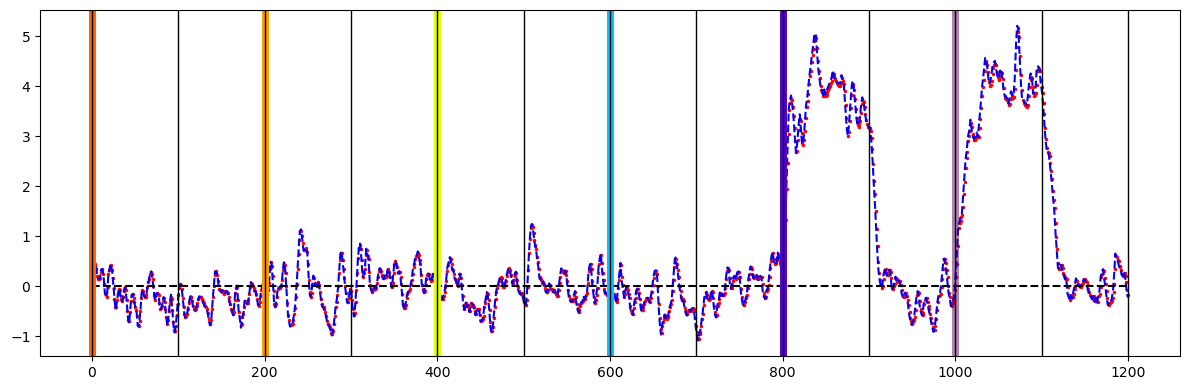

In [177]:
cmap_list = get_list_of_colors(nLEDs, red_first=True)

roi = 200
N = ticks_per_template * nLEDs
ticks = int(N / (nLEDs))

t = np.linspace(0, N, pooled_traces_bs_control.shape[1])
t_ds = np.linspace(0, N, traces_ds_control.shape[1])

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(t_ds, traces_ds_control[roi, :], 'r.', label="downsampled data", markersize=3)
ax.plot(t, pooled_traces_bs_control[roi, :], 'b--', label="raw data", markersize=3)
ax.hlines(0, 0, N, 'k', '--')
for i in range(nLEDs):
    ax.axvline((i*ticks), c = cmap_list[i], lw = 5)
for i in range(2*nLEDs+1):
    ax.axvline((i*ticks/2), c = 'k', lw = 1)


## **get cone tuning curves**

In [178]:
path_to_cone_data = r"..\experiment_info\model\cone_data.csv"
cone_tunings, cone_tuning_columns = get_cone_tunings(path_to_cone_data, N_ticks_extra=templates.shape[0])

## **get log opsin tuning curves**

In [179]:
log_opsin_tuning, opsins = get_log_opsin_tunings()

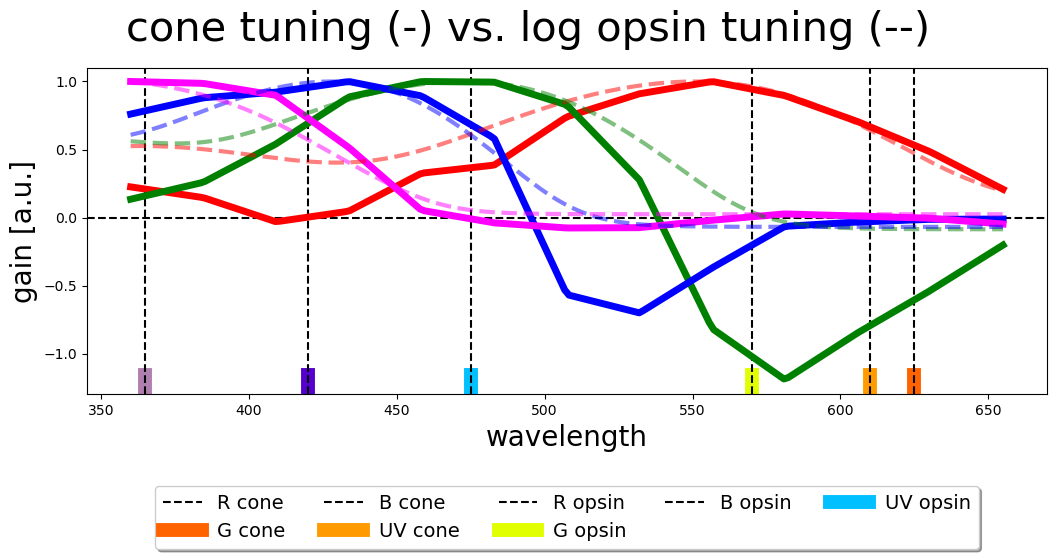

In [180]:
aspect_ratio = 1920 / 1080
height = 6
fig, ax = plt.subplots(1, 1, figsize=(height*aspect_ratio, height))
legend_labels = ['R cone', 'G cone', 'B cone', 'UV cone', 'R opsin', 'G opsin', 'B opsin', 'UV opsin']

fig.suptitle("cone tuning (-) vs. log opsin tuning (--)", fontsize=30)
ax.axhline(y=0, color='k', linestyle='--')

ax.set_ylabel('gain [a.u.]', fontsize=20)
ax.set_ylim(-1.3, 1.1)
fig.gca().set_xlabel(r'$\lambda$ [nm]', fontsize=20)
# ax.set_xlabel('wavelength [nm]', fontsize=20)

for id, led in enumerate(led_nms_num):
    ax.axvline(led, ymin=0, ymax=.06, c = cmap_list[id], lw = 10)
    ax.axvline(led, c='k', ls='--')

cone_tunings.plot(x="wavelength", y=cone_tuning_columns[1:], color=['r', 'g', 'b', 'magenta'], style='-', linewidth=5, legend=True, ax=ax)
log_opsin_tuning.plot(x='wavelength', y=opsins, color=['r', 'g', 'b', 'magenta'], style='--', legend=True, linewidth=3, alpha=0.5, ax=ax)
ax.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=5, fontsize=14)
plt.tight_layout()


# **get spectral components for each template**

In [186]:
temp_columns = ['Ltr_red', 'Ltr_green', 'Ltr_blue', 'Ltr_uv',
                'Lsus_red', 'Lsus_green', 'Lsus_blue', 'Lsus_uv',
                'Dtr_red', 'Dtr_green', 'Dtr_blue', 'Dtr_uv',
                'Dsus_red', 'Dsus_green', 'Dsus_blue', 'Dsus_uv']

# create an empty array to hold the interpolated templates: temporal components weighted by gains of each cone for a given LED wavelength
cone_templates_control = np.zeros((ticks_to_interpolate, len(temp_columns)))

'''get templates for control data'''
# for each LED
for led, nm in enumerate(led_nms):
      # get idx of the closest wavelength [nm] from interpolated cone tunings
      idx = get_closest_wavelength(cone_tunings['wavelength'], float(nm))
      
      # print the closest wavelength and its corresponding gains
      print('idx: ', idx, 'nm: ', nm, 'wv: ', cone_tunings['wavelength'].iloc[idx], 'nm |', 'red gain:', 
            cone_tunings['Red'].iloc[idx], "| green gain:", cone_tunings['Green'].iloc[idx], "| blue gain:", 
            cone_tunings['Blue'].iloc[idx], "| uv gain:", cone_tunings['UV'].iloc[idx])

      # get weights = gains of each cone type for a given LED wavelength
      # there are 4 types of templates: [Ltr, Lsus, Dtr, Dsus] that repeat for each LED -> 4x4 weights in total
      weights = cone_tunings[cone_tuning_columns[1:]].iloc[idx].to_numpy()

      for temp_type in range(4):
            template_broadcasted = np.broadcast_to(templates[:, temp_type, np.newaxis], (templates.shape[0], weights.shape[0])).copy()
            weighted_templates = template_broadcasted * weights
            cone_templates_control[led*200:(led+1)*200, temp_type*4:(temp_type+1)*4:] = weighted_templates
      
'''get templates for 'ablated' data'''
ablated_components_red = ['Ltr_red', 'Lsus_red', 'Dtr_red', 'Dsus_red']
ablated_components_green = ['Ltr_green', 'Lsus_green', 'Dtr_green', 'Dsus_green']
ablated_components_blue = ['Ltr_blue', 'Lsus_blue', 'Dtr_blue', 'Dsus_blue']
ablated_components_uv = ['Ltr_uv', 'Lsus_uv', 'Dtr_uv', 'Dsus_uv']
# red ablated

cone_templates_red = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_red[ablated_components_red] = 0 # kill red cone components
# red ablation modifies the green and blue cone components, so we need to update the red cone templates
for led, nm in enumerate(led_nms):
      # get idx of the closest wavelength [nm] from interpolated log opsin tunings
      idx = get_closest_wavelength(log_opsin_tuning['wavelength'], float(nm))
      
      # print the closest wavelength and its corresponding gains
      print('log opsin idx: ', idx, 'nm: ', nm, 'wv: ', log_opsin_tuning['wavelength'].iloc[idx], 'nm |', 'red gain:', 
            log_opsin_tuning['R'].iloc[idx], "| green gain:", log_opsin_tuning['G'].iloc[idx], "| blue gain:", 
            log_opsin_tuning['B'].iloc[idx], "| uv gain:", log_opsin_tuning['U'].iloc[idx])

      # get weight = gain of red cone for a given LED wavelength
      for cone_type_, ablated_components_ in zip(['G', 'B'], [ablated_components_green, ablated_components_blue]):
            weight = log_opsin_tuning[cone_type_].iloc[idx]
            weighted_templates = templates * weight
            cone_templates_red.loc[led*200:(led+1)*200-1, ablated_components_] = weighted_templates
cone_templates_red = cone_templates_red.to_numpy()

# green ablated
cone_templates_green = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_green[ablated_components_green] = 0 # kill green cone components
cone_templates_green = cone_templates_green.to_numpy()

# blue ablated
cone_templates_blue = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_blue[ablated_components_blue] = 0 # kill blue cone components
cone_templates_blue = cone_templates_blue.to_numpy()

# uv ablated
cone_templates_uv = pd.DataFrame(cone_templates_control.copy(), columns=temp_columns)
cone_templates_uv[ablated_components_uv] = 0 # kill uv cone components
# UV ablation modifies the red cone components, so we need to update the red cone templates
for led, nm in enumerate(led_nms):
      # get idx of the closest wavelength [nm] from interpolated log opsin tunings
      idx = get_closest_wavelength(log_opsin_tuning['wavelength'], float(nm))
      
      # print the closest wavelength and its corresponding gains
      print('log opsin idx: ', idx, 'nm: ', nm, 'wv: ', log_opsin_tuning['wavelength'].iloc[idx], 'nm |', 'red gain:', 
            log_opsin_tuning['R'].iloc[idx], "| green gain:", log_opsin_tuning['G'].iloc[idx], "| blue gain:", 
            log_opsin_tuning['B'].iloc[idx], "| uv gain:", log_opsin_tuning['U'].iloc[idx])

      # get weight = gain of red cone for a given LED wavelength
      weight = log_opsin_tuning['R'].iloc[idx]
      weighted_templates = templates * weight
      cone_templates_uv.loc[led*200:(led+1)*200-1, ablated_components_red] = weighted_templates
cone_templates_uv = cone_templates_uv.to_numpy()


idx:  20 nm:  625 wv:  625.3517587939698 nm | red gain: 0.5284241557788948 | green gain: -0.6008514974874376 | blue gain: -0.017150774874371888 | uv gain: -0.001718048341708519
idx:  30 nm:  610 wv:  610.5276381909548 nm | red gain: 0.6628597336683417 | green gain: -0.7885212462311557 | blue gain: -0.029168262311557783 | uv gain: 0.008168317487437182
idx:  57 nm:  570 wv:  570.5025125628141 nm | red gain: 0.9414448241206028 | green gain: -1.0280811608040208 | blue gain: -0.19807583417085364 | uv gain: 0.006337903517588037
idx:  121 nm:  475 wv:  475.6281407035176 nm | red gain: 0.36745426130653264 | green gain: 0.9966927638190956 | blue gain: 0.6754564170854273 | uv gain: -0.011780287939698458
idx:  159 nm:  420 wv:  419.2964824120603 nm | red gain: 0.0007014316582914168 | green gain: 0.6829966834170853 | blue gain: 0.9539602060301507 | uv gain: 0.7401965728643218
idx:  196 nm:  365 wv:  364.4472361809045 nm | red gain: 0.2107909648241207 | green gain: 0.15701161306532646 | blue gain: 

# **fit templates**

In [189]:
fit_responses_control, weights_control = fit_model(traces_ds_control, cone_templates_control)
fit_responses_uv, weights_uv = fit_model(traces_ds_uv, cone_templates_uv)
fit_responses_green, weights_green = fit_model(traces_ds_green, cone_templates_green)
fit_responses_red, weights_red = fit_model(traces_ds_red, cone_templates_red)
fit_responses_blue, weights_blue = fit_model(traces_ds_blue, cone_templates_blue)

# **plot residuals**